# T7 - Calibration

<div class="alert alert-info">
    
An interactive version of this notebook is available on [Google Colab](https://colab.research.google.com/github/starsimhub/starsim/blob/main/docs/tutorials/tut_calibration.ipynb?install=starsim) or [Binder](https://mybinder.org/v2/gh/starsimhub/starsim/HEAD?labpath=docs%2Ftutorials%2Ftut_calibration.ipynb).
    
</div>

Disease models typically require contextualization to a relevant setting of interest prior to addressing "what-if" scenario questions. The process of tuning model input parameters so that model outputs match observed data is known as calibration. There are many approaches to model calibration, ranging from manual tuning to fully Bayesian methods.

For many applications, we have found that an optimization-based approach is sufficient. Such methods avoid the tedious process of manual tuning and are less computationally expensive than fully Bayesian methods. One such optimization-based approach is the Optuna library, which is a Bayesian hyperparameter optimization framework. Optuna is designed for tuning hyperparameters of machine learning models, but it can also be used to calibrate disease models.

Calibration libraries often treat the disease model as a black box, where the input parameters are the "hyperparameters" to be tuned. The calibration process is often iterative and requires a combination of expert knowledge and computational tools. The optimization algorithm iteratively chooses new parameter values to evaluate, and the model is run with these values to generate outputs. The outputs are compared to observed data, and a loss function is calculated to quantify the difference between the model outputs and the observed data. The optimization algorithm then uses this loss function to update its search strategy and choose new parameter values to evaluate. This process continues until the algorithm converges to a set of parameter values that minimize the loss function.

While many optimization algorithms are available, Starsim has a built-in interface to the Optuna library, which we will demonstrate in this tutorial. We will use a simple Susceptible-Infected-Recovered (SIR) model as an example. We will tune three input parameters, the infectivity parameter, `beta`, the initial prevalence parameter, `init_prev`, and the Poisson-distributed degree distribution parameter, `n_contacts`. We will calibrate the model using a beta-binomial likelihood function so as to match prevalence at three distinct time points.

We begin with a few imports and default settings:

In [1]:
#%% Imports and settings
import sciris as sc
import starsim as ss
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

n_agents = 2e3
debug = False # If true, will run in serial

/Users/dklein/miniforge3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The calibration class will require a base `Sim` object. This `sim` will later be modified according to parameters selected by the optimization engine. The following function creates the base `Sim` object.

In [2]:
def make_sim():
    sir = ss.SIR(
        beta = ss.beta(0.075),
        init_prev = ss.bernoulli(0.02),
    )
    random = ss.RandomNet(n_contacts=ss.poisson(4))

    sim = ss.Sim(
        n_agents = n_agents,
        start = sc.date('2020-01-01'),
        stop = sc.date('2020-02-12'),
        dt = 1,
        unit = 'day',
        diseases = sir,
        networks = random,
        verbose = 0,
    )

    return sim

Now let's define the calibration parameters. These are the inputs that Optuna will be able to modify. Here, we define three such parameters, `beta`, `init_prev`, and `n_contacts`.

Each parameter entry should have range defined by `low` and `high` as well as a `guess` values. The `guess` value is not used by Optuna, rather only for a check after calibration completes to see if the new parameters are better than the `guess` values.

You'll notice there are a few other parameters that can be specified. For example, the data type of the parameter appears in `suggest_type`. Possible values are listed in the Optuna documentation, and include [suggest_float](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_float) for float values and [suggest_int](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_int) for integer types.

To make things easier for the search algorithm, it's helpful to indicate how outputs are expected to change with inputs. For example, increasing `beta` from 0.01 to 0.02 should double disease transmission, but increasing from 0.11 to 0.12 will have a small effect. Thus, we indicate that this parameter should be calibrated with `log=True`.

In [3]:
# Define the calibration parameters
calib_pars = dict(
    beta = dict(low=0.01, high=0.30, guess=0.15, suggest_type='suggest_float', log=True), # Note the log scale
    init_prev = dict(low=0.01, high=0.05, guess=0.15), # Default type is suggest_float, no need to re-specify
    n_contacts = dict(low=2, high=10, guess=3, suggest_type='suggest_int'), # Suggest int just for this demo
)

The optimization engine iteratively chooses input parameters to simulate. Those parameters are passed into the following `build_sim` function as a dictionary of `calib_pars` along with the base `sim` and any other key word arguments. The `calib_pars` will be as above, but importantly will have an additional key named `value` containing the value selected by Optuna.

When modifying a `sim`, it is important to realize that the simulation has not been initialized yet. Nonetheless, the configuration is available for modification at `sim.pars`, as demonstrated in the function below for the SIR example.

In [4]:
def build_sim(sim, calib_pars, n_reps=1, **kwargs):
    """
    Modify the base simulation by applying calib_pars. The result can be a
    single simulation or multiple simulations if n_reps>1. Note that here we are
    simply building the simulation by modifying the base sim. Running the sims
    and extracting results will be done by the calibration function.
    """

    sir = sim.pars.diseases # There is only one disease in this simulation and it is a SIR
    net = sim.pars.networks # There is only one network in this simulation and it is a RandomNet

    for k, pars in calib_pars.items(): # Loop over the calibration parameters
        if k == 'rand_seed':
            sim.pars.rand_seed = v
            continue

        # Each item in calib_pars is a dictionary with keys like 'low', 'high',
        # 'guess', 'suggest_type', and importantly 'value'. The 'value' key is
        # the one we want to use as that's the one selected by the algorithm
        v = pars['value']
        if k == 'beta':
            sir.pars.beta = ss.beta(v)
        elif k == 'init_prev':
            sir.pars.init_prev = ss.bernoulli(v)
        elif k == 'n_contacts':
            net.pars.n_contacts = ss.poisson(v)
        else:
            raise NotImplementedError(f'Parameter {k} not recognized')

    # If just one simulation per parameter set, return the single simulation
    if n_reps == 1:
        return sim

    # But if you'd like to run multiple simulations with the same parameters, we return a MultiSim instead
    # Note that each simulation will have a different random seed, you can set specific seeds if you like
    # Also note that parallel=False and debug=True are important to avoid issues with parallelism in the calibration
    # Advanced: If running multiple reps, you can choose if/how they are combined using the "combine_reps" argument to each CalibComponent, introduced below.
    ms = ss.MultiSim(sim, iterpars=dict(rand_seed=np.random.randint(0, 1e6, n_reps)), initialize=True, debug=True, parallel=False)
    return ms

The Starsim framework has been integrated with the Optuna hyperparameter optimization algorithm to facilitate calibration through the `Calibration` class. Recall that an optimization-based approach to calibration minimizes a function of the input parameters. This function is key to achieving an acceptable calibration.

There are two ways to describe the goodness-of-fit function for the `Calibration`. The first method is to directly provide a function that the algorithm will call. The `eval_fn` will be passed each completed `sim` after running, and is expected to return a float representing the **mismatch (lower is better as the optimization algorithm is configured to minimize)**. Data can be passed into the `eval_fn` via `eval_kwargs`.

As an alternative to directly specifying the evaluation function, you can use `CalibComponent`s. Each component includes real data, for example from a survey, that is compared against simulation data from the model. Several components and be used at the same time, for example one for disease prevalence and another for treatment coverage. Each component computes a likelihood of the data given the input parameters, as assessed via simulation. Components are combined assuming independence.

The base class for a component is called `CalibComponent`, which you can use to define your own likelihood. However, we have provided components for several key likelihood functions including `BetaBinomial`, `Binomial`, `DirichletMultinomial`, `GammaPoisson`, and `Normal`. The `Normal` component is most like a traditional squared error. Each component takes in a `name` and a `weight`, which is used when combining log likelihoods.

Importantly, each component takes in the calibration target, the real data that was observed, in an argument called `expected`. This argument should be a Pandas Dataframe with one row per time point and columns that will depend on the specific component type. For example, the `Binomial` component requires columns of `n` (trials) and `x` (successes).

The components also handle extracting data from each simulation using the `extract_fn` argument. The value of this argument should be a function that takes in a simulation and returns a Pandas DataFrame. The specifics of the columns will depend a bit on the type of component (e.g. `BetaBinomial` is different from `Normal`), but often looks like a simulated version of `expected`. We will see examples below.

We'll also see how to use the `conform` argument, the purpose of which is to temporally align the simulation output to the real data. This argument works along with the `extract_fn` to produce the final simulation outputs that are used in the likelihood function. The conformer is a function that takes in the `expected` data you provided and the `actual` simulation result the comes out of the `extract_fn`. The conformers we have built in are as follows:
* `step_containing`: Conform by simply choosing the simulated timestep that contains the time indicated in the real data (`expected`)
* `prevalent`: Interpolate the simulated timepoints to estimate the values that would have occurred at each real timepoint
* `incident`: While the two methods above capture the state of the model at a particular point in time (stocks), this component allows you to capture the behavior of the model over time (flows). Instead of just giving one time value, `t`, you'll provide a second time value as well called `t1`. This conformer will add up events occurring between the two time points.

Let's make a Binomial component, as might be used to calibrate disease prevalence.

In [5]:
prevalence = ss.Normal(
    name = 'Disease prevalence',
    conform = 'prevalent',

    expected = pd.DataFrame({
        'x': [0.13, 0.16, 0.06],    # Prevalence of infection
    }, index=pd.Index([ss.date(d) for d in ['2020-01-12', '2020-01-25', '2020-02-02']], name='t')), # On these dates
    
    extract_fn = lambda sim: pd.DataFrame({
        'x': sim.results.sir.prevalence,
    }, index=pd.Index(sim.results.timevec, name='t')),

    # You can specify the variance as well, but it's optional (max likelihood estimates will be used if not provided)
    # This could be a single float or an array with the same shape as the expected values
    sigma2 = 0.05, # e.g. (num_replicates/sigma2_model + 1/sigma2_data)^-1
    #sigma2 = np.array([0.05, 0.25, 0.01])
)

Finally, we can bring all the pieces together. We make a single base simulation and create an instance of a Starsim Calibration object. This object requires a few arguments, like the `calib_pars` and `sim`. We also pass in the function that modifies the base `sim`, here our `build_sim` function. No additional `build_kw` are required in this example.

We also pass in a list of `components`. Instead of using this "component-based" system, a user could simply provide an `eval_fn`, which takes in a completed sim an any `eval_kwargs` and returns a "mismatch" score to be minimized.

We can also specify the total number of trials to run, the number of parallel works, and a few other parameters.

In [6]:
sc.heading('Beginning calibration')

# Make the sim and data
sim = make_sim()

# Make the calibration
calib = ss.Calibration(
    calib_pars = calib_pars,
    sim = sim,
    build_fn = build_sim,
    build_kw = dict(n_reps=3), # Run 3 replicates for each parameter set
    reseed = True, # If true, a different random seed will be provided to each configuration
    components = [prevalence],
    total_trials = 100,
    n_workers = None, # None indicates to use all available CPUs
    die = True,
    debug = debug, # Run in serial if True
)

# Perform the calibration
sc.printcyan('\nPeforming calibration...')
calib.calibrate();



—————————————————————
Beginning calibration
—————————————————————


Peforming calibration...
Removed existing calibration file starsim_calibration.db
sqlite:///starsim_calibration.db


[I 2024-12-20 16:00:38,353] A new study created in RDB with name: starsim_calibration


Elapsed time: 0.380 sElapsed time: 0.386 sElapsed time: 0.348 s


Elapsed time: 0.394 s
Elapsed time: 0.409 s
Elapsed time: 0.417 s

[I 2024-12-20 16:00:39,259] Trial 2 finished with value: -1.5038560240388945 and parameters: {'beta': 0.1459926507355202, 'init_prev': 0.024923149369891994, 'n_contacts': 7, 'rand_seed': 926513}. Best is trial 2 with value: -1.5038560240388945.


[I 2024-12-20 16:00:39,263] Trial 1 finished with value: -4.229693374394067 and parameters: {'beta': 0.10840309076435325, 'init_prev': 0.045151617781834456, 'n_contacts': 3, 'rand_seed': 690961}. Best is trial 1 with value: -4.229693374394067.


Elapsed time: 0.386 s

[I 2024-12-20 16:00:39,278] Trial 3 finished with value: -4.62271497424883 and parameters: {'beta': 0.13467289467458593, 'init_prev': 0.012011852877203322, 'n_contacts': 3, 'rand_seed': 800642}. Best is trial 3 with value: -4.62271497424883.


[I 2024-12-20 16:00:39,284] Trial 4 finished with value: -2.057739983268287 and parameters: {'beta': 0.1251769155645099, 'init_prev': 0.026652468236656405, 'n_contacts': 8, 'rand_seed': 321076}. Best is trial 3 with value: -4.62271497424883.


Elapsed time: 0.413 s


[I 2024-12-20 16:00:39,314] Trial 7 finished with value: 0.5881043756917026 and parameters: {'beta': 0.11002363525131198, 'init_prev': 0.034078119705397855, 'n_contacts': 7, 'rand_seed': 422323}. Best is trial 3 with value: -4.62271497424883.
[I 2024-12-20 16:00:39,315] Trial 5 finished with value: -3.8376909934215346 and parameters: {'beta': 0.011411329708797697, 'init_prev': 0.04766358742338284, 'n_contacts': 2, 'rand_seed': 654083}. Best is trial 3 with value: -4.62271497424883.


Elapsed time: 0.439 s


[I 2024-12-20 16:00:39,335] Trial 0 finished with value: -3.022330598792606 and parameters: {'beta': 0.13950866275318455, 'init_prev': 0.014866441845597139, 'n_contacts': 10, 'rand_seed': 345201}. Best is trial 3 with value: -4.62271497424883.
[I 2024-12-20 16:00:39,357] Trial 6 finished with value: -4.097153725107551 and parameters: {'beta': 0.01932508130475975, 'init_prev': 0.02302518603119227, 'n_contacts': 8, 'rand_seed': 386107}. Best is trial 8 with value: -4.938141313561331.
[I 2024-12-20 16:00:39,373] Trial 8 finished with value: -4.938141313561331 and parameters: {'beta': 0.040062491480843905, 'init_prev': 0.039826599599249335, 'n_contacts': 6, 'rand_seed': 306497}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.423 s


[I 2024-12-20 16:00:39,481] Trial 9 finished with value: -1.7736304893910022 and parameters: {'beta': 0.04867203067320204, 'init_prev': 0.03245893376587917, 'n_contacts': 9, 'rand_seed': 371309}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.304 s


[I 2024-12-20 16:00:39,674] Trial 12 finished with value: -4.274863228273637 and parameters: {'beta': 0.2435433460437845, 'init_prev': 0.010436818898123352, 'n_contacts': 8, 'rand_seed': 153866}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.328 s
Elapsed time: 0.311 s

[I 2024-12-20 16:00:39,705] Trial 11 finished with value: 4.7901470384339735 and parameters: {'beta': 0.09208006674163068, 'init_prev': 0.010258824581650585, 'n_contacts': 9, 'rand_seed': 328640}. Best is trial 8 with value: -4.938141313561331.



Elapsed time: 0.323 sElapsed time: 0.324 s

Elapsed time: 0.302 s


[I 2024-12-20 16:00:39,739] Trial 14 finished with value: 4.413091436785666 and parameters: {'beta': 0.08074077974453561, 'init_prev': 0.018133106086657743, 'n_contacts': 10, 'rand_seed': 83759}. Best is trial 8 with value: -4.938141313561331.
[I 2024-12-20 16:00:39,749] Trial 13 finished with value: -4.250601900009894 and parameters: {'beta': 0.15923773250984422, 'init_prev': 0.026325381568221094, 'n_contacts': 9, 'rand_seed': 916713}. Best is trial 8 with value: -4.938141313561331.
[I 2024-12-20 16:00:39,752] Trial 10 finished with value: -3.8717817241131627 and parameters: {'beta': 0.010424691010962604, 'init_prev': 0.044405069626759865, 'n_contacts': 5, 'rand_seed': 458448}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.306 s
Elapsed time: 0.329 s
Elapsed time: 0.295 s


[I 2024-12-20 16:00:39,801] Trial 15 finished with value: -1.5694741297934374 and parameters: {'beta': 0.062225186701716555, 'init_prev': 0.038133686910295464, 'n_contacts': 7, 'rand_seed': 775974}. Best is trial 8 with value: -4.938141313561331.
[I 2024-12-20 16:00:39,822] Trial 18 finished with value: -4.314874839487979 and parameters: {'beta': 0.22919228134133016, 'init_prev': 0.02968443310280488, 'n_contacts': 7, 'rand_seed': 964405}. Best is trial 8 with value: -4.938141313561331.
[I 2024-12-20 16:00:39,845] Trial 16 finished with value: -3.8580172464855353 and parameters: {'beta': 0.021111307458905996, 'init_prev': 0.042963671992955414, 'n_contacts': 2, 'rand_seed': 148345}. Best is trial 8 with value: -4.938141313561331.
[I 2024-12-20 16:00:39,848] Trial 17 finished with value: -2.3418438935551324 and parameters: {'beta': 0.04389998995695997, 'init_prev': 0.049540942658607943, 'n_contacts': 9, 'rand_seed': 816292}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.295 s


[I 2024-12-20 16:00:39,917] Trial 19 finished with value: -4.329987841386632 and parameters: {'beta': 0.03998586018675045, 'init_prev': 0.03859653828709257, 'n_contacts': 4, 'rand_seed': 85665}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.279 s


[I 2024-12-20 16:00:40,064] Trial 20 finished with value: -4.638649750808565 and parameters: {'beta': 0.04773616725134784, 'init_prev': 0.03969289705407539, 'n_contacts': 4, 'rand_seed': 35286}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.300 s
Elapsed time: 0.284 s
Elapsed time: 0.292 s


[I 2024-12-20 16:00:40,165] Trial 21 finished with value: -4.430329115884332 and parameters: {'beta': 0.04266851966513858, 'init_prev': 0.04128712459019136, 'n_contacts': 4, 'rand_seed': 8876}. Best is trial 8 with value: -4.938141313561331.
[I 2024-12-20 16:00:40,168] Trial 22 finished with value: -4.260846696819007 and parameters: {'beta': 0.0378945295780117, 'init_prev': 0.03917720865424426, 'n_contacts': 4, 'rand_seed': 644697}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.302 s

[I 2024-12-20 16:00:40,178] Trial 24 finished with value: -4.342032989190928 and parameters: {'beta': 0.04000173715496126, 'init_prev': 0.038170002157912636, 'n_contacts': 4, 'rand_seed': 698061}. Best is trial 8 with value: -4.938141313561331.



Elapsed time: 0.292 s


[I 2024-12-20 16:00:40,203] Trial 23 finished with value: -4.315592019858983 and parameters: {'beta': 0.04103590901692494, 'init_prev': 0.03744655328925691, 'n_contacts': 4, 'rand_seed': 682893}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.291 s

[I 2024-12-20 16:00:40,215] Trial 25 finished with value: -4.408558666515453 and parameters: {'beta': 0.04235089954171719, 'init_prev': 0.03828041132600634, 'n_contacts': 4, 'rand_seed': 577579}. Best is trial 8 with value: -4.938141313561331.


[I 2024-12-20 16:00:40,274] Trial 26 finished with value: -4.171600788612042 and parameters: {'beta': 0.03572752246566628, 'init_prev': 0.03811704556060719, 'n_contacts': 4, 'rand_seed': 625781}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.289 s
Elapsed time: 0.295 s
Elapsed time: 0.283 s


[I 2024-12-20 16:00:40,321] Trial 29 finished with value: -4.14129926176408 and parameters: {'beta': 0.032667543060714746, 'init_prev': 0.019566716981190217, 'n_contacts': 5, 'rand_seed': 575224}. Best is trial 8 with value: -4.938141313561331.
[I 2024-12-20 16:00:40,320] Trial 28 finished with value: -4.161335839090416 and parameters: {'beta': 0.03459060046473737, 'init_prev': 0.038693427787979504, 'n_contacts': 4, 'rand_seed': 613228}. Best is trial 8 with value: -4.938141313561331.
[I 2024-12-20 16:00:40,327] Trial 27 finished with value: -4.109417881109481 and parameters: {'beta': 0.03204537971166361, 'init_prev': 0.03744413464767457, 'n_contacts': 4, 'rand_seed': 561898}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.293 s


[I 2024-12-20 16:00:40,475] Trial 30 finished with value: -4.210885411444349 and parameters: {'beta': 0.030098923775530605, 'init_prev': 0.038399061579543106, 'n_contacts': 5, 'rand_seed': 558951}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.289 s


[I 2024-12-20 16:00:40,562] Trial 32 finished with value: -4.016783527899798 and parameters: {'beta': 0.023016163789709936, 'init_prev': 0.03375167668081845, 'n_contacts': 5, 'rand_seed': 521668}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.291 s


[I 2024-12-20 16:00:40,607] Trial 34 finished with value: -4.006221146541492 and parameters: {'beta': 0.02436265640821072, 'init_prev': 0.03281276554567798, 'n_contacts': 5, 'rand_seed': 245959}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.320 sElapsed time: 0.295 s

Elapsed time: 0.316 s


[I 2024-12-20 16:00:40,636] Trial 35 finished with value: -4.189339486875761 and parameters: {'beta': 0.02848054413308232, 'init_prev': 0.03416453915252862, 'n_contacts': 5, 'rand_seed': 232814}. Best is trial 8 with value: -4.938141313561331.
[I 2024-12-20 16:00:40,647] Trial 31 finished with value: -4.196884554820861 and parameters: {'beta': 0.02984742026289613, 'init_prev': 0.033560377922708814, 'n_contacts': 5, 'rand_seed': 248372}. Best is trial 8 with value: -4.938141313561331.
[I 2024-12-20 16:00:40,653] Trial 33 finished with value: -4.430118565169037 and parameters: {'beta': 0.06689381096412914, 'init_prev': 0.03408718038753146, 'n_contacts': 5, 'rand_seed': 531995}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.324 s
Elapsed time: 0.314 s
Elapsed time: 0.298 s


[I 2024-12-20 16:00:40,736] Trial 36 finished with value: -2.0644254924669507 and parameters: {'beta': 0.06824672288469338, 'init_prev': 0.03341134604133303, 'n_contacts': 6, 'rand_seed': 198250}. Best is trial 8 with value: -4.938141313561331.
[I 2024-12-20 16:00:40,736] Trial 37 finished with value: -3.440158530423552 and parameters: {'beta': 0.06264719242240517, 'init_prev': 0.03314812315980617, 'n_contacts': 6, 'rand_seed': 254523}. Best is trial 8 with value: -4.938141313561331.
[I 2024-12-20 16:00:40,752] Trial 38 finished with value: -3.52235039539197 and parameters: {'beta': 0.06309991026025703, 'init_prev': 0.03437120642893802, 'n_contacts': 6, 'rand_seed': 251463}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.305 s


[I 2024-12-20 16:00:40,801] Trial 39 finished with value: -0.8364675720122542 and parameters: {'beta': 0.07696424989785167, 'init_prev': 0.03357593084180763, 'n_contacts': 6, 'rand_seed': 267351}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.298 s


[I 2024-12-20 16:00:40,885] Trial 40 finished with value: -4.660997047420464 and parameters: {'beta': 0.0619141769615071, 'init_prev': 0.04211357989358043, 'n_contacts': 3, 'rand_seed': 7866}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.284 s


[I 2024-12-20 16:00:40,958] Trial 41 finished with value: -4.523591368691607 and parameters: {'beta': 0.06266261060385737, 'init_prev': 0.04349652029309987, 'n_contacts': 3, 'rand_seed': 5719}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.276 s


[I 2024-12-20 16:00:41,000] Trial 42 finished with value: -4.423192229073843 and parameters: {'beta': 0.05685809751522748, 'init_prev': 0.042031562504341764, 'n_contacts': 3, 'rand_seed': 24817}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.271 s


[I 2024-12-20 16:00:41,041] Trial 44 finished with value: -3.8567735559177656 and parameters: {'beta': 0.015359932233185056, 'init_prev': 0.041056594008701444, 'n_contacts': 3, 'rand_seed': 929}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.311 sElapsed time: 0.262 s



[I 2024-12-20 16:00:41,086] Trial 43 finished with value: -4.635127155939892 and parameters: {'beta': 0.06128284149978157, 'init_prev': 0.04158985332531902, 'n_contacts': 3, 'rand_seed': 1536}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.283 s


[I 2024-12-20 16:00:41,103] Trial 46 finished with value: -3.8756819035389247 and parameters: {'beta': 0.01623314049927441, 'init_prev': 0.04143306267481944, 'n_contacts': 3, 'rand_seed': 11772}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.260 s

[I 2024-12-20 16:00:41,125] Trial 47 finished with value: -3.8693207993994365 and parameters: {'beta': 0.016197986845124385, 'init_prev': 0.04158957874848265, 'n_contacts': 3, 'rand_seed': 12939}. Best is trial 8 with value: -4.938141313561331.


[I 2024-12-20 16:00:41,145] Trial 45 finished with value: -3.8731153734536568 and parameters: {'beta': 0.01696534288980633, 'init_prev': 0.04290138622802599, 'n_contacts': 3, 'rand_seed': 2880}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.264 s


[I 2024-12-20 16:00:41,176] Trial 48 finished with value: -3.8820869291353333 and parameters: {'beta': 0.017053889340360635, 'init_prev': 0.04208783987937995, 'n_contacts': 3, 'rand_seed': 23980}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.279 s


[I 2024-12-20 16:00:41,207] Trial 49 finished with value: -3.8631392821836252 and parameters: {'beta': 0.01827083994397335, 'init_prev': 0.04217866285990905, 'n_contacts': 3, 'rand_seed': 27484}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.279 s


[I 2024-12-20 16:00:41,281] Trial 50 finished with value: -4.310184748988916 and parameters: {'beta': 0.051851135414499754, 'init_prev': 0.042406941945192775, 'n_contacts': 3, 'rand_seed': 8151}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.289 s
Elapsed time: 0.264 s


[I 2024-12-20 16:00:41,370] Trial 51 finished with value: -4.354091675123136 and parameters: {'beta': 0.05225082327964827, 'init_prev': 0.04576341833212888, 'n_contacts': 3, 'rand_seed': 4627}. Best is trial 8 with value: -4.938141313561331.
[I 2024-12-20 16:00:41,380] Trial 52 finished with value: -3.895478754490038 and parameters: {'beta': 0.016047756443261695, 'init_prev': 0.046376756123617045, 'n_contacts': 3, 'rand_seed': 73074}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.273 s
Elapsed time: 0.272 s


[I 2024-12-20 16:00:41,455] Trial 54 finished with value: -4.979340615213812 and parameters: {'beta': 0.13145630159592656, 'init_prev': 0.04626056827752253, 'n_contacts': 2, 'rand_seed': 79570}. Best is trial 54 with value: -4.979340615213812.
[I 2024-12-20 16:00:41,456] Trial 53 finished with value: -3.2127778955241886 and parameters: {'beta': 0.18273300035009113, 'init_prev': 0.04548213089975238, 'n_contacts': 2, 'rand_seed': 128728}. Best is trial 8 with value: -4.938141313561331.


Elapsed time: 0.302 s
Elapsed time: 0.269 s
Elapsed time: 0.290 s


[I 2024-12-20 16:00:41,513] Trial 55 finished with value: -4.783025410108172 and parameters: {'beta': 0.102808713482873, 'init_prev': 0.04638360500841188, 'n_contacts': 2, 'rand_seed': 93138}. Best is trial 54 with value: -4.979340615213812.
[I 2024-12-20 16:00:41,530] Trial 57 finished with value: -4.776412400307333 and parameters: {'beta': 0.104888276681347, 'init_prev': 0.046348275116856026, 'n_contacts': 2, 'rand_seed': 70234}. Best is trial 54 with value: -4.979340615213812.
[I 2024-12-20 16:00:41,531] Trial 56 finished with value: -4.8482486651676115 and parameters: {'beta': 0.11250407807351329, 'init_prev': 0.045691517122563405, 'n_contacts': 2, 'rand_seed': 75129}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.271 s
Elapsed time: 0.264 s

[I 2024-12-20 16:00:41,589] Trial 58 finished with value: -4.72890196989736 and parameters: {'beta': 0.10232769232492461, 'init_prev': 0.04655818101512553, 'n_contacts': 2, 'rand_seed': 94977}. Best is trial 54 with value: -4.979340615213812.


[I 2024-12-20 16:00:41,607] Trial 59 finished with value: -3.9777684720615385 and parameters: {'beta': 0.05249085985604662, 'init_prev': 0.04648776012667511, 'n_contacts': 2, 'rand_seed': 103149}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.262 s


[I 2024-12-20 16:00:41,660] Trial 60 finished with value: -4.8278028370828885 and parameters: {'beta': 0.10915215156041642, 'init_prev': 0.04586962476956923, 'n_contacts': 2, 'rand_seed': 102364}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.263 s


[I 2024-12-20 16:00:41,736] Trial 61 finished with value: -4.716136456734741 and parameters: {'beta': 0.10039710335191555, 'init_prev': 0.04976113415905724, 'n_contacts': 2, 'rand_seed': 132246}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.278 s


[I 2024-12-20 16:00:41,775] Trial 62 finished with value: -4.8190475312865635 and parameters: {'beta': 0.10300429301769573, 'init_prev': 0.048748891586685265, 'n_contacts': 2, 'rand_seed': 118947}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.262 s
Elapsed time: 0.295 s


[I 2024-12-20 16:00:41,837] Trial 64 finished with value: -4.820497918696105 and parameters: {'beta': 0.1147375603267886, 'init_prev': 0.04975219125873691, 'n_contacts': 2, 'rand_seed': 99041}. Best is trial 54 with value: -4.979340615213812.
[I 2024-12-20 16:00:41,844] Trial 63 finished with value: -4.880067317968199 and parameters: {'beta': 0.10829717308658456, 'init_prev': 0.04957719183940608, 'n_contacts': 2, 'rand_seed': 111765}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.259 s
Elapsed time: 0.290 sElapsed time: 0.284 s



[I 2024-12-20 16:00:41,909] Trial 67 finished with value: -4.755847612178602 and parameters: {'beta': 0.10536999608583267, 'init_prev': 0.04925808881607039, 'n_contacts': 2, 'rand_seed': 115618}. Best is trial 54 with value: -4.979340615213812.
[I 2024-12-20 16:00:41,931] Trial 65 finished with value: -4.927496230817945 and parameters: {'beta': 0.11862624891907021, 'init_prev': 0.049497002847976534, 'n_contacts': 2, 'rand_seed': 113536}. Best is trial 54 with value: -4.979340615213812.
[I 2024-12-20 16:00:41,931] Trial 66 finished with value: -4.851138523279916 and parameters: {'beta': 0.11010414838363693, 'init_prev': 0.0496467955738314, 'n_contacts': 2, 'rand_seed': 121659}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.281 s


[I 2024-12-20 16:00:41,986] Trial 68 finished with value: -4.830502344293007 and parameters: {'beta': 0.11147641408977448, 'init_prev': 0.049167279706911066, 'n_contacts': 2, 'rand_seed': 162918}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.304 s


[I 2024-12-20 16:00:42,069] Trial 69 finished with value: -4.809025656787282 and parameters: {'beta': 0.11112990162788447, 'init_prev': 0.049421288901171104, 'n_contacts': 2, 'rand_seed': 171143}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.301 s


[I 2024-12-20 16:00:42,101] Trial 70 finished with value: -4.861670421310773 and parameters: {'beta': 0.11063919159182815, 'init_prev': 0.04993876974278014, 'n_contacts': 2, 'rand_seed': 180466}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.302 s


[I 2024-12-20 16:00:42,150] Trial 71 finished with value: -4.8926027882003815 and parameters: {'beta': 0.11815427732946213, 'init_prev': 0.047893664352647025, 'n_contacts': 2, 'rand_seed': 172066}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.315 s


[I 2024-12-20 16:00:42,205] Trial 72 finished with value: -4.917797705982596 and parameters: {'beta': 0.11934924486173906, 'init_prev': 0.04831585704579853, 'n_contacts': 2, 'rand_seed': 186949}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.301 sElapsed time: 0.303 s



[I 2024-12-20 16:00:42,249] Trial 73 finished with value: -4.651225333747696 and parameters: {'beta': 0.1378777596387443, 'init_prev': 0.04842132037318839, 'n_contacts': 2, 'rand_seed': 198543}. Best is trial 54 with value: -4.979340615213812.
[I 2024-12-20 16:00:42,250] Trial 74 finished with value: -4.907362689872102 and parameters: {'beta': 0.12980297906210655, 'init_prev': 0.04813334196848594, 'n_contacts': 2, 'rand_seed': 182797}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.276 s
Elapsed time: 0.324 s
Elapsed time: 0.295 s

[I 2024-12-20 16:00:42,338] Trial 75 finished with value: -4.741608878679263 and parameters: {'beta': 0.1398455508454206, 'init_prev': 0.04790552979029056, 'n_contacts': 2, 'rand_seed': 180102}. Best is trial 54 with value: -4.979340615213812.


[I 2024-12-20 16:00:42,353] Trial 76 finished with value: -4.1979713404874595 and parameters: {'beta': 0.1411478153189135, 'init_prev': 0.04764975927644782, 'n_contacts': 8, 'rand_seed': 175733}. Best is trial 54 with value: -4.979340615213812.
[I 2024-12-20 16:00:42,368] Trial 77 finished with value: -4.1751286443114815 and parameters: {'beta': 0.1435981884633475, 'init_prev': 0.048294167676107704, 'n_contacts': 8, 'rand_seed': 172428}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.309 s


[I 2024-12-20 16:00:42,435] Trial 78 finished with value: -4.267195207992088 and parameters: {'beta': 0.14205694742914635, 'init_prev': 0.047796288076894795, 'n_contacts': 8, 'rand_seed': 174868}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.313 s


[I 2024-12-20 16:00:42,520] Trial 79 finished with value: -4.323719203733876 and parameters: {'beta': 0.13956637940187822, 'init_prev': 0.04787790133225781, 'n_contacts': 10, 'rand_seed': 194318}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.303 s


[I 2024-12-20 16:00:42,556] Trial 80 finished with value: -4.228206864095454 and parameters: {'beta': 0.1409978983428116, 'init_prev': 0.04788149218513643, 'n_contacts': 8, 'rand_seed': 185826}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.324 s


[I 2024-12-20 16:00:42,629] Trial 81 finished with value: -4.242026381847827 and parameters: {'beta': 0.1456205946541705, 'init_prev': 0.047911677253213526, 'n_contacts': 8, 'rand_seed': 194280}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.303 s
Elapsed time: 0.302 s

[I 2024-12-20 16:00:42,663] Trial 82 finished with value: -4.6529588661592705 and parameters: {'beta': 0.14169684374863156, 'init_prev': 0.0477822629292277, 'n_contacts': 2, 'rand_seed': 301974}. Best is trial 54 with value: -4.979340615213812.



Elapsed time: 0.332 s


[I 2024-12-20 16:00:42,693] Trial 83 finished with value: -4.3189423137879315 and parameters: {'beta': 0.1577250202903256, 'init_prev': 0.04788118994299007, 'n_contacts': 8, 'rand_seed': 314246}. Best is trial 54 with value: -4.979340615213812.
[I 2024-12-20 16:00:42,722] Trial 84 finished with value: -4.214439867515417 and parameters: {'beta': 0.16730150008968517, 'init_prev': 0.04759441923705178, 'n_contacts': 10, 'rand_seed': 320881}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.325 s
Elapsed time: 0.316 s
Elapsed time: 0.304 s


[I 2024-12-20 16:00:42,792] Trial 85 finished with value: -4.275700779977308 and parameters: {'beta': 0.15576464941624155, 'init_prev': 0.044542346543091985, 'n_contacts': 10, 'rand_seed': 318978}. Best is trial 54 with value: -4.979340615213812.
[I 2024-12-20 16:00:42,803] Trial 86 finished with value: -3.740353098873938 and parameters: {'beta': 0.17217214000588443, 'init_prev': 0.0445076693768897, 'n_contacts': 2, 'rand_seed': 342507}. Best is trial 54 with value: -4.979340615213812.
[I 2024-12-20 16:00:42,804] Trial 87 finished with value: -3.632097158679347 and parameters: {'beta': 0.1769197091545095, 'init_prev': 0.04396893504807394, 'n_contacts': 2, 'rand_seed': 307514}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.298 s


[I 2024-12-20 16:00:42,860] Trial 88 finished with value: -4.109842783735449 and parameters: {'beta': 0.16784052853818807, 'init_prev': 0.044859495094050725, 'n_contacts': 2, 'rand_seed': 285157}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.283 s


[I 2024-12-20 16:00:42,906] Trial 89 finished with value: -4.041126067627122 and parameters: {'beta': 0.168183973695388, 'init_prev': 0.04427196641595682, 'n_contacts': 2, 'rand_seed': 341032}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.280 s


[I 2024-12-20 16:00:42,957] Trial 90 finished with value: -4.273439887075452 and parameters: {'beta': 0.1666860368124998, 'init_prev': 0.04410794108964566, 'n_contacts': 2, 'rand_seed': 301193}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.259 s


[I 2024-12-20 16:00:43,057] Trial 92 finished with value: -2.7801203823177794 and parameters: {'beta': 0.20284124774550297, 'init_prev': 0.044132412571929104, 'n_contacts': 2, 'rand_seed': 57979}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.266 s


[I 2024-12-20 16:00:43,077] Trial 93 finished with value: -4.491894121584378 and parameters: {'beta': 0.08849434038847984, 'init_prev': 0.044364746872069316, 'n_contacts': 2, 'rand_seed': 218345}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.270 s
Elapsed time: 0.274 s


[I 2024-12-20 16:00:43,112] Trial 91 finished with value: -3.6706326564748917 and parameters: {'beta': 0.17385739257798472, 'init_prev': 0.043591778251109714, 'n_contacts': 2, 'rand_seed': 301007}. Best is trial 54 with value: -4.979340615213812.
[I 2024-12-20 16:00:43,123] Trial 94 finished with value: -4.516665697890672 and parameters: {'beta': 0.08800919027447283, 'init_prev': 0.044304785804600746, 'n_contacts': 2, 'rand_seed': 397796}. Best is trial 54 with value: -4.979340615213812.


Elapsed time: 0.261 s
Elapsed time: 0.275 s


[I 2024-12-20 16:00:43,172] Trial 95 finished with value: -4.537854030601633 and parameters: {'beta': 0.08908688253333136, 'init_prev': 0.049894319107641014, 'n_contacts': 2, 'rand_seed': 52984}. Best is trial 54 with value: -4.979340615213812.
[I 2024-12-20 16:00:43,174] Trial 96 finished with value: -5.0043272817595446 and parameters: {'beta': 0.12411437609329659, 'init_prev': 0.035489082417424093, 'n_contacts': 2, 'rand_seed': 223711}. Best is trial 96 with value: -5.0043272817595446.


Elapsed time: 0.247 s
Elapsed time: 0.285 s


[I 2024-12-20 16:00:43,235] Trial 97 finished with value: -4.415077357252889 and parameters: {'beta': 0.08655966870035582, 'init_prev': 0.04968124042374451, 'n_contacts': 2, 'rand_seed': 57687}. Best is trial 96 with value: -5.0043272817595446.
[I 2024-12-20 16:00:43,245] Trial 98 finished with value: -0.41466276071422703 and parameters: {'beta': 0.08872905959071943, 'init_prev': 0.046875740149513186, 'n_contacts': 7, 'rand_seed': 222178}. Best is trial 96 with value: -5.0043272817595446.


Elapsed time: 0.270 s


[I 2024-12-20 16:00:43,277] Trial 99 finished with value: 0.9609244675743469 and parameters: {'beta': 0.08927934998963412, 'init_prev': 0.035842077428948196, 'n_contacts': 7, 'rand_seed': 378316}. Best is trial 96 with value: -5.0043272817595446.


Making results structure...
Processed 100 trials; 0 failed
Best pars: {'beta': 0.12411437609329659, 'init_prev': 0.035489082417424093, 'n_contacts': 2, 'rand_seed': 223711}
Removed existing calibration file starsim_calibration.db


Let's look at the best parameters that were found. Note that the `rand_seed` was selected at random, but the other parameters are meaningful.

In [7]:
calib.best_pars

{'beta': 0.12411437609329659,
 'init_prev': 0.035489082417424093,
 'n_contacts': 2,
 'rand_seed': 223711}

Once the calibration is complete, we can compare the `guess` values to the best values found by calling `check_fit`.

In [8]:
# Confirm - Note the comparison is here configured over n_reps=15 replicates
sc.printcyan('\nConfirming fit...')

# Increase replicates to 15 for more representative results when running check_fit
calib.build_kw['n_reps'] = 15

calib.check_fit(do_plot=False)


Confirming fit...

Checking fit...
Elapsed time: 0.511 s
Fit with original pars: -17.65926212012544
Fit with best-fit pars: -25.011851242962056
✓ Calibration improved fit -17.65926212012544 --> -25.011851242962056


True

After calling `check_fit`, we can plot the results. This first plot shows the Normal likelihood distributions from each of the 15 simulations we did in `check_fit` as the colored lines. The vertical dashed line is located at the real (`expected`) data. Top row is the "guess" values and the bottom row is the new "best" parameters. We want the vertical dashed line to cross the Gaussians at high points, representing high likelihood.

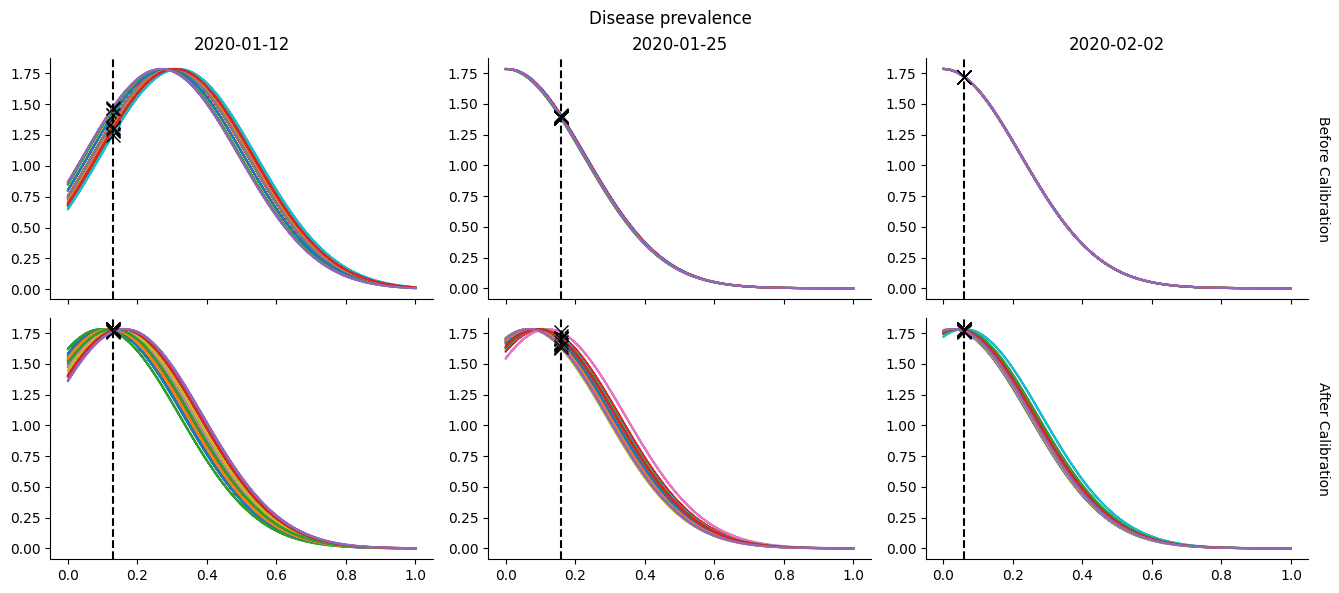

In [9]:
calib.plot();

Another way to plot the results is via bootstrapping. Here we repeatedly choose 15 from the `n_reps=15` simulations (with replacement), compute the average (or sum for some components), and repeatedly calculate the mean. We then plot the distribution of means, and hope it lands near the vertical dashed lines representing the real data.

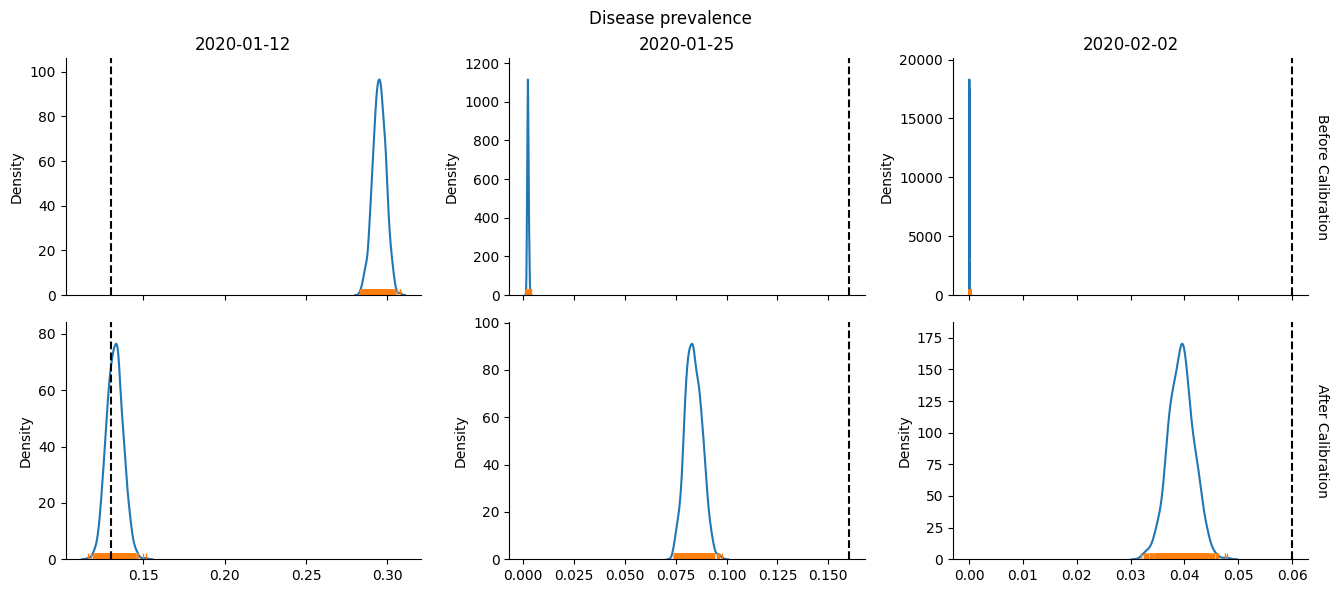

In [10]:
calib.plot(bootstrap=True); # Pass bootstrap=True to produce this plot

We can view some plots of the final fitted results. Whereas the two plots above were from the `check_fit`, running both "guess" and "best" parameters, here we make make new simulations to visualize the results.

Elapsed time: 1.28 s


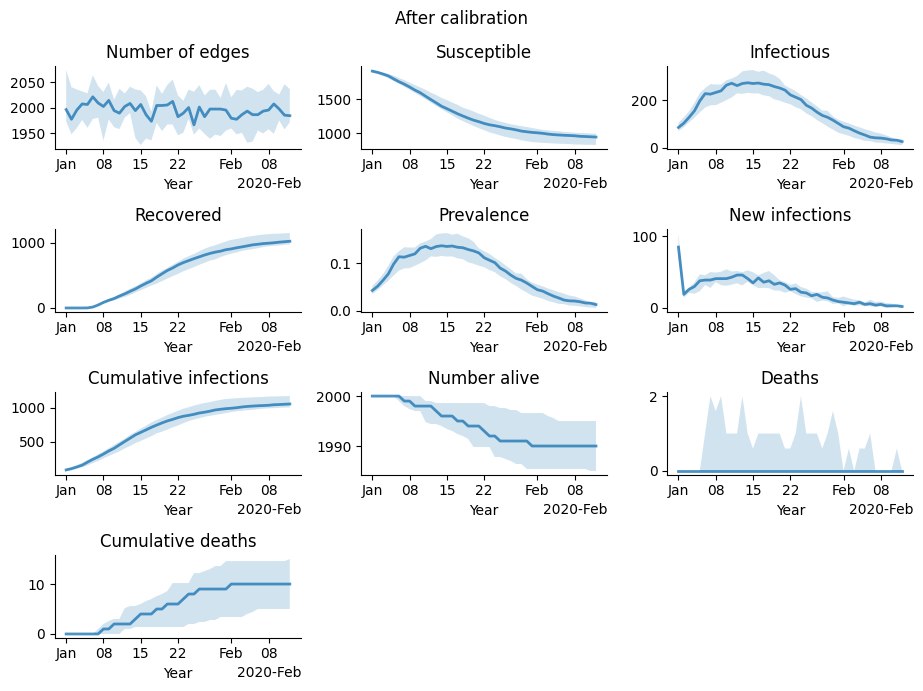

In [11]:
g = calib.plot_final(); # Run the model for 10 replicates
for ax in g.axes: # Fix the date formatting
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

Optuna has lots of diagnostic plots that we can explore. Possible plots include:
* plot_contour
* plot_edf
* plot_hypervolume_history
* plot_intermediate_values
* plot_optimization_history
* plot_parallel_coordinate
* plot_param_importances
* plot_pareto_front
* plot_rank
* plot_slice
* plot_terminator_improvement
* plot_timeline

Here are some examples:

/Users/dklein/GIT/starsim/starsim/calibration.py:438: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = getattr(vis, method)(self.study)


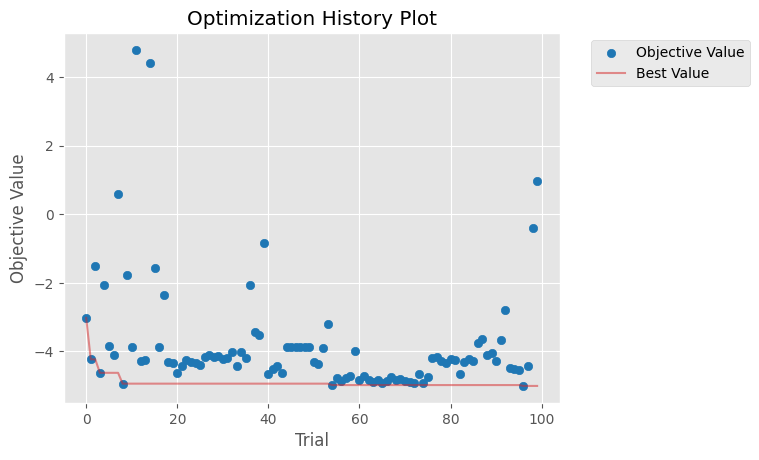

In [12]:
calib.plot_optuna('plot_optimization_history'); # Plot the optimization history

/Users/dklein/GIT/starsim/starsim/calibration.py:438: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = getattr(vis, method)(self.study)
[W 2024-12-20 16:00:53,216] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


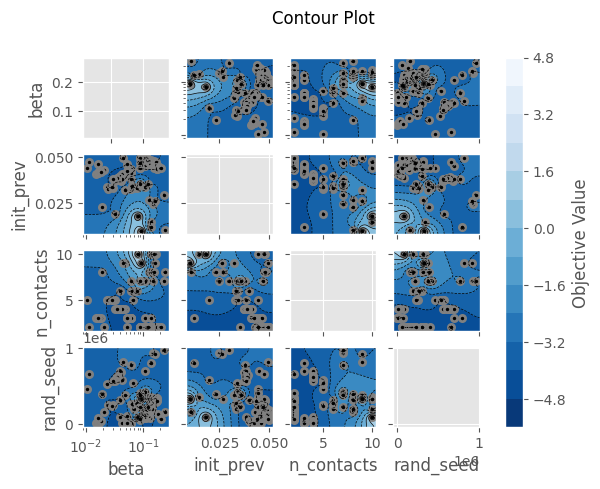

In [13]:
calib.plot_optuna('plot_contour');

/Users/dklein/GIT/starsim/starsim/calibration.py:438: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = getattr(vis, method)(self.study)


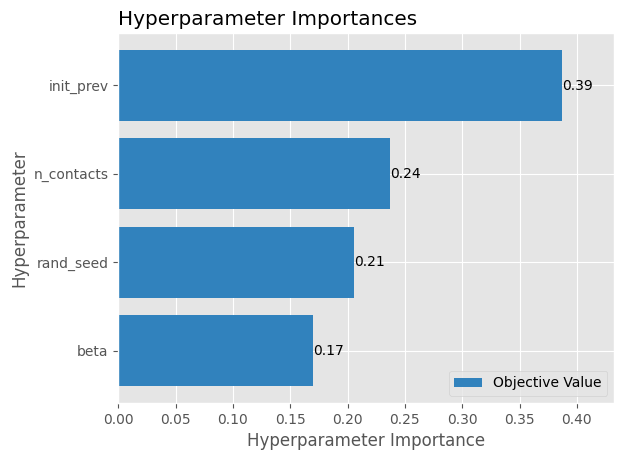

In [14]:
calib.plot_optuna('plot_param_importances');